<h3><b><span style="color:red">Author: Salvatore Porcheddu
<br>Date: 2021-03-28</span></b></h3>
</body>


# Introduction

Data Science is a very broad concept, encompassing many different fields such as computer science, statistics, mathematics and so on. With such broadness, if you are a Data Science student or a company that wants to offer Data Science courses, it can be pretty complex to determine which Data Science topics you should focus on given their general popularity and demand.

This project sets out to provide an answer to this problem, but without considering the economic standpoint: this means that we will not directly focus on what companies employing data scientists WANT from their data specialists but instead we will concentrate on what Data Science students and practitioners usually discuss about, in other words we will determine which Data Science topics are the most popular within the Data Science community.

One metric that could be used to determine if a topic is popular or not is how many questions people ask about it and how many answers they receive: we will try to apply this principle to [Stack Exchange](https://stackexchange.com/), an online community where people can ask questions about various subjects, which in turn may receive answers from other users.

Stack Exchange has a subcommunity exclusively dedicated to Data Science, [Data Science Stack Exchange](https://datascience.stackexchange.com/) and offers public access to databases (*Data Explorer*) related to all of its subcommunities in order to extract information about them.

We will query the Data Science database, and in particular the **Posts** table which contains general information about every non-deleted post: we will focus on the columns:
- *ID*: identifies the post with a number;
- *PostTypeId*: identifies what type the post is with a number; there are 8 different IDs, but most of them are very rarely used and in practice only questions (ID = 1) and answers (ID = 2) are relevant for us. Given the high number of these, we will only extract the questions;
- *CreationDate*: the date and time the post was created; to simplify the analysis, we will restrict the analysis to the year 2019;
- *Score*: the score can be used as a measure of the popularity of the post;
- *ViewCount*: the number of times that people have viewed the post;
- *Tags*: topics associated with the post;
- *AnswerCount*: number of answers the question has received (not applicable if the post is not a question);
- *FavoriteCount*: number of times that people favored the question (only for questions).

After querying the database and saving the data as a csv file, we can load it as a dataframe with pandas:

In [102]:
import pandas as pd

questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

print(questions.shape)
questions.head()

(8839, 7)


,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


# Exploring and cleaning the data

As we can see, our dataframe has 8839 rows and 7 columns (we have excluded the *PostTypeId* column since all the posts are questions and thus have the same post type ID). 

We can immediately see that the `FavoriteCount` column of our dataframe contains some missing values.

Let's see how many missing values there are in the dataframe:

In [103]:
questions.isna().sum(axis=0)

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

It seems that the `FavoriteCount` column is the only source of missing values; we can also see that they are preponderant and we may be tempted to drop the column altogether.

Before deciding what to do with these missing values, let's see what other kinds of values we can find in the column:

In [104]:
questions["FavoriteCount"].value_counts()

1.0     953
2.0     205
0.0     175
3.0      43
4.0      12
5.0       8
6.0       4
7.0       4
11.0      1
8.0       1
16.0      1
Name: FavoriteCount, dtype: int64

Even though the column already contains the value 0, we should be able to assimilate the missing values as zeros:



In [105]:
questions["FavoriteCount"] = questions["FavoriteCount"].fillna(0)

Now let's turn our attention to the column types to see if they are appropriate:

In [106]:
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount           float64
dtype: object

There's only one minor problem with the dtypes and it's again with the `FavoriteCount` column which, for some reason, contains floats even though none of the values have decimals. Let's fix that:

In [107]:
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)

### Counting tags and views

Let's now move forward and analyse the `Tags` column. We can immediately see that this column needs some cleaning, and in particular the single tags need to be separated so that we can work with them:

In [108]:
questions["Tags"].value_counts().head(20)

<machine-learning>                    118
<python><pandas>                       58
<python>                               55
<r>                                    38
<tensorflow>                           36
<neural-network>                       35
<nlp>                                  35
<reinforcement-learning>               32
<keras>                                29
<deep-learning>                        29
<time-series>                          26
<keras><tensorflow>                    24
<classification>                       23
<machine-learning><python>             23
<python><pandas><dataframe>            22
<machine-learning><neural-network>     21
<clustering>                           21
<cnn>                                  19
<machine-learning><deep-learning>      18
<dataset>                              17
Name: Tags, dtype: int64

We will proceed by removing the angle quotation marks and replace them with a comma, then split the strings to obtain a list:

In [109]:
questions["Tags"] = questions["Tags"].str.replace("><", ",").str.replace("<", "").str.replace(">", "")
questions["Tags"] = questions["Tags"].str.split(",")

Now that the `Tags` column is in a format that we can work with, we want to know:

- how many times each tag was used;
- how many times each tag was viewed.

First, we will need to create a set of tags in order to isolate the unique tags and automatically remove any duplicates.

In [110]:
# create a set to store all the unique tags
tag_set = set()
for List in questions["Tags"]:
    for i in List:
        tag_set.add(i)

# counting each tag
tag_counts = {}
for tag in tag_set:
    Count = questions["Tags"].str.contains(tag, regex=False).sum()
    tag_counts[tag] = Count
    
# counting the number of times a tag was viewed 
tag_views = {}
for tag in tag_set:
    Views = questions.loc[questions["Tags"].str.contains(tag, regex=False), "ViewCount"].sum()
    tag_views[tag] = Views

# let's create pandas series containing our tag data
TAG_counts = pd.Series(tag_counts)
TAG_views = pd.Series(tag_views)

# Let's see five example rows from our two new series
print(TAG_counts.head())
TAG_views.head()

.net                    1
3d-object-detection     1
3d-reconstruction       9
ab-test                 6
accuracy               89
dtype: int64


.net                     438
3d-object-detection        7
3d-reconstruction       1129
ab-test                  153
accuracy               15233
dtype: int64

Now that we have tag counts and views, we can find out **which tags were used most frequently and which ones attracted more users** (in terms of views).

We will focus on the top 20 tags for each of the two pandas series that we have created: we will therefore need to arrange the tags in descending order based on the count/number of views and then collect the first twenty. We will then plot these top 20 tags.

Let's start with the counts:


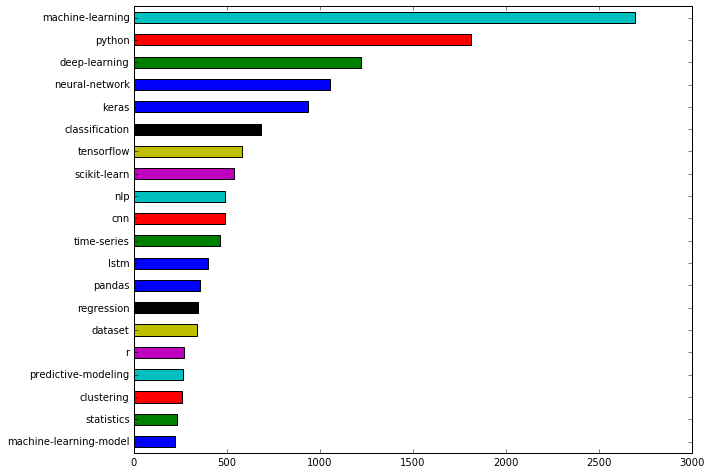

In [120]:
top20_counts = TAG_counts.sort_values(ascending=False).head(20)

import matplotlib.pyplot as plt
%matplotlib inline

top20_counts.sort_values(ascending=True).plot(kind="barh", figsize=(10, 8))
plt.show()

As we can see, the two most frequent tags are by far *machine-learning* and *python*; in general, the majority of the tags in the top 20 relate to machine learning or deep learning, for example *deep-learning*, *neural-network*, *keras*, *tensorflow*, *scikit-learn* etc.

Outside of the machine learning/deep learning domain, notable tags are *time-series*, *pandas*, *dataset* and *statistics*; the *r* tag is also fairly popular among the programming languages used in data science.

Will the most viewed tags be pretty much the same or will we have relevant differences? Let's answer this question by plotting the top 20 tags by view count:

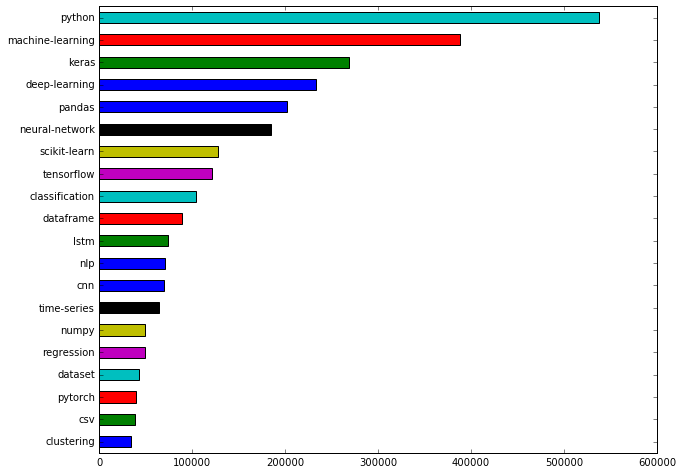

In [121]:
top20_views = TAG_views.sort_values(ascending=False).head(20)

top20_views.sort_values(ascending=True).plot(kind="barh", figsize=(10, 8))
plt.show()

Even though we can see immediately see many familiar tags from the tag counts plot (machine learning subjects still dominate the ranking), this latest graph also shows some interesting deviations:

- *python* is the most viewed tag, while *machine-learning* is now second;
- *pandas* is far more popular in terms of views as it was in terms of counts;
- another python package, *numpy*, has found its way in the top 20, as well as the machine learning library *pytorch*;
- *r* has disappeared from the top 20, along with *statistics* and two minor tags related to machine learning (*machine-learning-model* and *predictive-modeling*);
- two new tags related to dataframes can be seen, *dataframe* and *csv*.

### Relationships between tags

The most popular tags that we have just seen and analyzed have strong relations with one other; in particular, we can assert that:

- *machine-learning* has strong relations with both *python* and *r*, as these programming languages both allow the creation and execution of machine learning algorithms, with machine learning algorithm and subfield tags such as *neural-network*, *classification*, *nlp*, *regression*, and with machine learning libraries/frameworks such as *tensorflow*, *pytorch*, *scikit-learn*;
- *deep-learning* has strong relations with *python*, *r*, the *keras* API, and with *machine-learning* as deep learning can be viewed as a class of machine learning algorithms;
- the python libraries *pandas*, *numpy*, *scikit-learn* are obviously related to python; *tensorflow*, *pytorch* and *keras* are also related to python, as they function based on this programming language;
- *pandas* is also strongly related to dataframe manipulation and visualization tags such as *dataframe*, *dataset*, *time-series*, *csv* and with the python library *numpy*, which it uses for example to vectorize dataframe operations and more;
- *numpy* can be used for statistical purposes and for machine learning purposes alongside other tools (such as scikit-learn), so it also has relationships with the *statistics*, *scikit-learn*, *tensorflow* and other machine learning related tags;
- *python* has a direct or indirect relationship with basically every tag in our top 20 lists except *r*; similarly, *r* has a direct or indirect relationship with every tag which describes a general data science field or subfield (*machine-learning*, *deep-learning*, *dataframe*, *classification*, *regression*, *time-series* and so on).

### Analyzing deep learning

Our analysis until now strongly shows that python is the most popular programming language in data science and that machine learning topics dominate the field. But what about deep learning? Will it be as popular in the future to deserve a separate treatment from other machine learning algorithms? Will it become even more popular than machine learning itself?

Though we cannot see the future, we can analyse the trends of deep learning related tags within a longer timespan than just the year 2019. This is what we will do in this section, starting from a csv file containing all the questions ever asked on the Data Science Stock Exchange up until (and including) 2019.

This new questions dataframe will contain three columns, the ID for each questions, its creation date and its tags:

In [113]:
# Loading the dataframe
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [114]:
# Working on the tags, like we did previously
all_questions["Tags"] = all_questions["Tags"].str.replace("><", ",").str.replace(">", "").str.replace("<", "").str.split(",")

# Filtering out tags not related to deep learning
# We have selected some of the most important deep learning related tags to filter the dataframe
condition = all_questions["Tags"].str.contains("deep-learning", regex=False) | \
all_questions["Tags"].str.contains("deep-network", regex=False) | \
all_questions["Tags"].str.contains("keras", regex=False) | \
all_questions["Tags"].str.contains("lstm", regex=False) | \
all_questions["Tags"].str.contains("neural-network", regex=False) | \
all_questions["Tags"].str.contains("pytorch", regex=False) | \
all_questions["Tags"].str.contains("rnn", regex=False) | \
all_questions["Tags"].str.contains("tensorflow", regex=False) | \
all_questions["Tags"].str.contains("theano", regex=False) | \
all_questions["Tags"].str.contains("torch", regex=False)

deep_learning_questions = all_questions[condition].copy()

print(deep_learning_questions.shape)
deep_learning_questions.head()

(6593, 3)


,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
3,45426,2019-02-12 04:51:49,[keras]
8,45433,2019-02-12 08:56:23,"[python, keras, tensorflow, lstm]"
9,45434,2019-02-12 09:09:01,"[neural-network, feature-selection, mlp]"


This new dataframe contains 6593 rows out of the initial 21576. 

We can see that some of the tags included in the deep learning dataframe are also heavily related to machine learning, such as *tensorflow*: unfortunately we must accept some degree of overlapping, due to the fact that deep learning itself is a field of machine learning.

The next step is determining whether deep learning has been growing or shrinking in popularity: we will do this by counting the number of new deep learning related questions by month, and subsequently visualizing the trend in a line plot.

In [115]:
deep_learning_questions.set_index("CreationDate", drop=True, inplace=True)

resampled_dl_questions = deep_learning_questions.drop(columns="Tags").resample("M").count()

resampled_dl_questions

,Id
CreationDate,
2014-05-31,1
2014-06-30,6
2014-07-31,6
2014-08-31,1
2014-09-30,1
2014-10-31,5
2014-11-30,4
2014-12-31,6
2015-01-31,3


The numbers already clearly show that deep learning questions have seen a tremendous growth in popularity in the last few years. Let's plot the full trend for visual clarity:

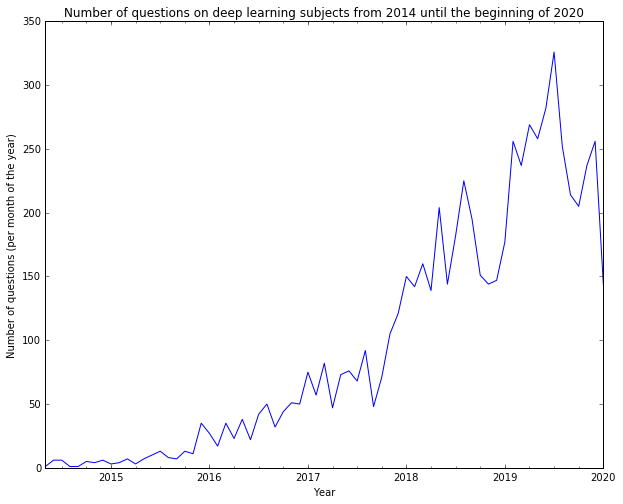

In [116]:
resampled_dl_questions.plot(figsize=(10, 8), legend=False)
plt.xlabel("Year")
plt.ylabel("Number of questions (per month of the year)")
plt.title("Number of questions on deep learning subjects from 2014 until the beginning of 2020")
plt.show()

There is still one problem though, because the absolute number of deep learning questions does not tell us necessarily that the topic has become more popular: what if the growth is just a product of a general increase in the number of questions asked throughout the Data Science Stack Exchange?

In order to be sure that the increase in the number of deep learning questions really reflects an increase in the popularity of deep learning subjects we need to monitor the fraction of deep learning questions over the total number of questions for each period of time that we are considering.

We will therefore have to go back to our `all_questions` dataframe and group the questions by month and year just as we previously did for the deep learning questions.

In [117]:
all_questions.set_index("CreationDate", drop=True, inplace=True)

resampled_all_questions = all_questions.drop(columns="Tags").resample("M").count()

resampled_all_questions

,Id
CreationDate,
2014-05-31,58
2014-06-30,99
2014-07-31,76
2014-08-31,65
2014-09-30,48
2014-10-31,71
2014-11-30,64
2014-12-31,81
2015-01-31,63


We can see that the entire Data Science Stack Exchange community seems to have seen a surge in popularity if we consider the number of questions asked as a metric for measuring such variable.

Now let's determine the fraction of questions related to deep learning over the global number of questions for each of the resampled periods and plot its tendency:

In [118]:
# We need to merge the two resampled pandas series
resampled_dl_questions.rename({"Id": "N_dl_questions"}, axis=1, inplace=True)
resampled_all_questions.rename({"Id": "N_all_questions"}, axis=1, inplace=True)

resampled_questions = resampled_dl_questions.merge(resampled_all_questions, left_index=True, right_index=True)

# Now we can add a new column with the fraction of dl questions
resampled_questions["fraction_dl_questions"] = resampled_questions["N_dl_questions"] / resampled_questions["N_all_questions"]

# The first five rows of the new dataframe look like this
resampled_questions.head()

,N_dl_questions,N_all_questions,fraction_dl_questions
CreationDate,,,
2014-05-31,1,58,0.017241
2014-06-30,6,99,0.060606
2014-07-31,6,76,0.078947
2014-08-31,1,65,0.015385
2014-09-30,1,48,0.020833


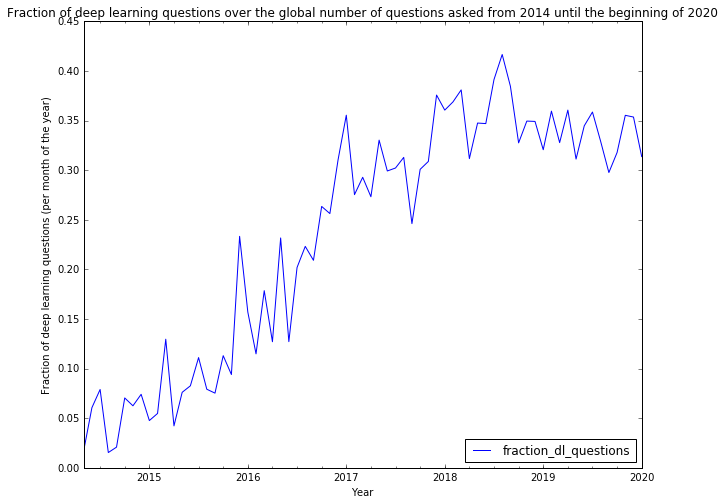

In [119]:
# Finally, we can plot the result
resampled_questions["fraction_dl_questions"].plot(figsize=(10, 8), legend=False)
plt.xlabel("Year")
plt.ylabel("Fraction of deep learning questions (per month of the year)")
plt.title("Fraction of deep learning questions over the global number of questions asked from 2014 until the beginning of 2020")
plt.legend(["fraction_dl_questions"], loc="lower right")
plt.show()

The line plot shows that deep learning questions have indeed seen an increase during the years: starting from just under 2% in May 2014, they reached a peak of almost 42% of the total number of questions in 2018!

From the plot we can also see that the fraction of deep learning questions has somewhat stabilized starting from 2018, ranging between 30 and 40%.

# Conclusion

So, **what topics should a Data Science student or a company offering Data Science courses focus on?**

The answer, according to our analysis, can be summarized as follows:

- the programming language of choice should be **Python** and/or **R**;
- data analysis themes such as **dataframes**, **data manipulation** and **data visualization** should not be neglected;
- machine learning subjects such as **supervised and unsupervised learning** algorithms make up the majority of popular tags in the Data Science Stack Exchange, and as such great attention should be put into them;
- Among machine learning subjects, special consideration should be given to **deep learning** concepts and algorithms such as **neural networks**, as **deep learning is the "hottest" Data Science area right now**;
- if the language of choice is Python, libraries and frameworks such as **Pandas**, **Numpy**, **Scikit-learn**, **Tensorflow**, **Pytorch** and **Keras** should be extensively covered. 